In [4]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import pyreadr
from pgmpy.utils import get_example_model
from pgmpy.inference import BeliefPropagation
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import matplotlib.pyplot as plt 
import networkx as nx
import pandas as pd 

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: C:\Users\Hasan\AppData\Local\Programs\R\R-4.4.0
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save


A brief problem description

Inference 

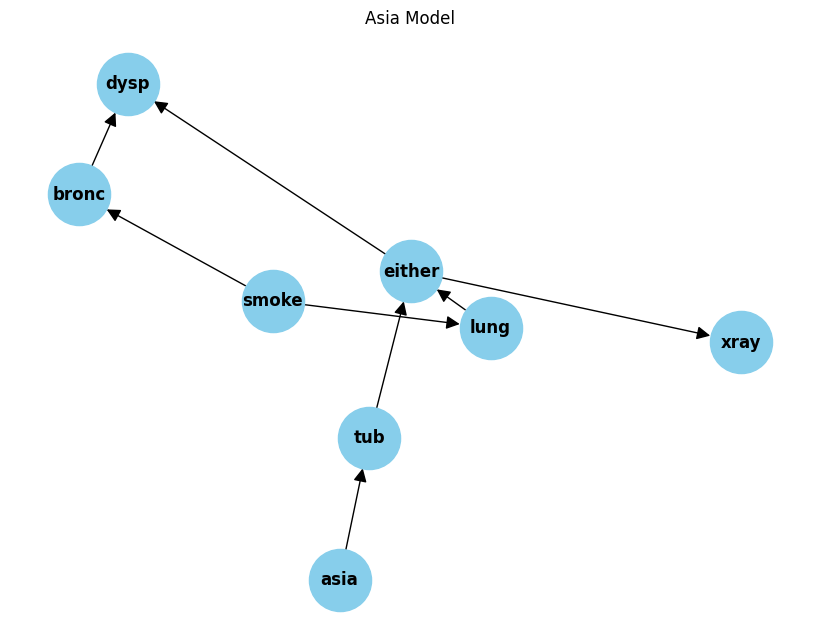

+-----------+------------+-------------------+
| asia      | smoke      |   phi(asia,smoke) |
+===========+============+===================+
| asia(yes) | smoke(yes) |            0.0091 |
+-----------+------------+-------------------+
| asia(yes) | smoke(no)  |            0.0009 |
+-----------+------------+-------------------+
| asia(no)  | smoke(yes) |            0.9000 |
+-----------+------------+-------------------+
| asia(no)  | smoke(no)  |            0.0900 |
+-----------+------------+-------------------+


In [5]:
asia_model = get_example_model('asia')

edges = asia_model.edges()
nodes = asia_model.nodes()

# Create NetworkX graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Plot the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
plt.title("Asia Model")
plt.show()

bp = BeliefPropagation(asia_model)

result = bp.query(variables=["asia", "smoke"], evidence={"lung": "yes"})
print(result)

Learning 

In [6]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

In [7]:
asia_model = get_example_model('asia')

edges = asia_model.edges()
nodes = asia_model.nodes()

values = pd.DataFrame(np.random.randint(low=0, high=2, size=(1000, len(nodes))),
                      columns=nodes)

estimator = MaximumLikelihoodEstimator(asia_model, values)

print(estimator.get_parameters())

for cpd in estimator.get_parameters():
    print(cpd)

[<TabularCPD representing P(asia:2) at 0x21fc17d6f10>, <TabularCPD representing P(tub:2 | asia:2) at 0x21fffd72090>, <TabularCPD representing P(smoke:2) at 0x21fbec16a50>, <TabularCPD representing P(lung:2 | smoke:2) at 0x21fc0831990>, <TabularCPD representing P(bronc:2 | smoke:2) at 0x21fc080d950>, <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x21fcbd41dd0>, <TabularCPD representing P(xray:2 | either:2) at 0x21fcbd42490>, <TabularCPD representing P(dysp:2 | bronc:2, either:2) at 0x21fcbd424d0>]
+---------+-----+
| asia(0) | 0.5 |
+---------+-----+
| asia(1) | 0.5 |
+---------+-----+
+--------+---------+---------+
| asia   | asia(0) | asia(1) |
+--------+---------+---------+
| tub(0) | 0.532   | 0.512   |
+--------+---------+---------+
| tub(1) | 0.468   | 0.488   |
+--------+---------+---------+
+----------+-------+
| smoke(0) | 0.503 |
+----------+-------+
| smoke(1) | 0.497 |
+----------+-------+
+---------+--------------------+--------------------+
| smoke   | smoke(0)  

In [34]:
import numpy as np
from pgmpy.models import FactorGraph
from pgmpy.factors.discrete import DiscreteFactor
import json

class FactorGraphEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, DiscreteFactor):
            return {
                "__class__": "DiscreteFactor",
                "__value__": {
                    "variables": [str(variable) for variable in obj.variables],
                    "cardinality": [int(card) for card in obj.cardinality],
                    "values": obj.values.tolist()
                }
            }
        return super().default(obj)

G = FactorGraph()
G.add_nodes_from(['a', 'b', 'c'])
phi1 = DiscreteFactor(['a', 'b'], [2, 3], np.random.rand(6))
phi2 = DiscreteFactor(['b', 'c'], [2, 4], np.random.rand(8))
G.add_factors(phi1, phi2)
G.add_nodes_from([phi1, phi2])
G.add_edges_from([('a', phi1), ('b', phi1),
                  ('b', phi2), ('c', phi2)])

# Serialize the data using the custom encoder
data = {
    "nodes": list(G.nodes()),
    "factors": G.get_factors(),
    "edges": list(G.edges())
}

with open('factor_graph.json', 'w') as json_file:
    json.dump(data, json_file, cls=FactorGraphEncoder, indent=4)